**Table of contents**<a id='toc0_'></a>    
- 1. [Mexico (Jalisco-Colima) pre-processing ](#toc1_)    
- 2. [Load data ](#toc2_)    
- 3. [Project along-strike ](#toc3_)    
- 4. [Count earthquakes that can trigger tremor ](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Mexico (Jalisco-Colima) pre-processing  [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'

# 2. <a id='toc2_'></a>Load data  [&#128285;](#toc0_)

In [3]:
# Constants
day0 = np.datetime64('2006-01-01')

In [4]:
# Load tremor
path = workdir + 'projects/data/Catalogs/world_tremor_database/jalisco_colima_wtb_0607.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
trm = pd.read_csv(
    path,
    names=COLS,
)

trm['date_str'] = trm.date.values + ' ' + trm.time.values
trm['date'] = pd.to_datetime(trm.date_str)
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

trm.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(trm.shape[0], trm.date.min().year, trm.date.max().year))

1411 tremor detections, spanning 2006--2007


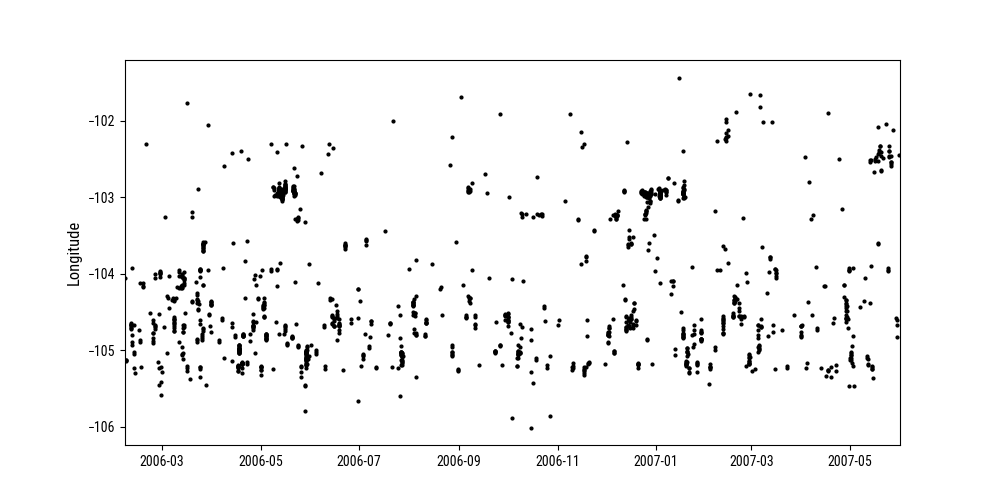

In [5]:
# Activity in time and space
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Longitude')
ax.plot(trm.date, trm.lon, 'k.', ms=4)
ax.set_xlim(np.datetime64('2006-02-06'), np.datetime64('2007-06-01'))
plt.show()

In [6]:
# Load earthquakes (Mexican catalog)
path = workdir + 'projects/data/Catalogs/mexico_ssn_0024/SSNMX_catalogo_20000101_20240418_utc.csv'
names = ['date', 'hour', 'mag', 'lat', 'lon', 'depth', 'loc', 'date_loc', 'hour_loc', 'status']

eq = pd.read_csv(path, names=names, skiprows=5, delimiter=',', low_memory=False)
eq.date = pd.to_datetime(eq.date + ' ' + eq.hour)

eq.mag = [float(m) if m != 'no calculable' else 0 for m in eq.mag]

eq['day'] = (eq.date - day0)/np.timedelta64(1, 'D')

depth = np.zeros(eq.shape[0])
for i, d in enumerate(eq.depth):
    try:
        depth[i] = float(d)
    except:
        if d == 'menos de 1':
            depth[i] = 0.
        else:
            depth[i] = -100.
eq['depth'] = depth

# # Load earthquakes (ISC catalog?)
# import requests
# import io

# # Geographic constraints (Jalisco-Colima region, ish)
# bot_lat = 16.0
# top_lat = 22.0
# left_lon = -108.0
# right_lon = -100.0
# geographic_region = f'bot_lat={bot_lat:.1f}&top_lat={top_lat:.1f}&left_lon={left_lon:.1f}&right_lon={right_lon:.1f}'

# # Time constraints
# start_year = '2000'
# start_month = '01'
# start_day = '01'
# end_year = '2024'
# end_month = '01'
# end_day = '01'
# time_range=f'start_year={start_year}&start_month={start_month}&start_day={start_day}&end_year={end_year}&end_month={end_month}&end_day={end_day}'

# url = f"http://www.isc.ac.uk/cgi-bin/web-db-run?out_format=CATCSV&request=REVIEWED&searchshape=RECT&{geographic_region}&{time_range}&req_mag_agcy=prime"
# print(url)

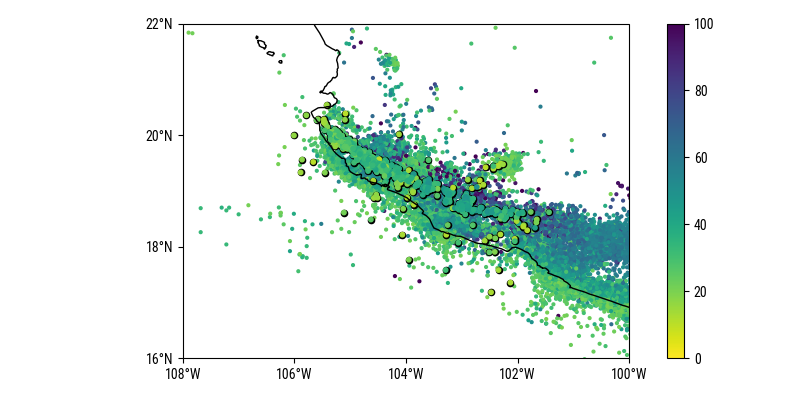

In [7]:
# Quick map
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()
sc = ax.scatter(eq.lon[eq.depth>20], eq.lat[eq.depth>20], c=eq.depth[eq.depth>20], vmin=0, vmax=100, s=4, transform=ccrs.PlateCarree(), cmap='viridis_r')
plt.colorbar(sc)

ax.scatter(trm.lon, trm.lat, c='k', s=20, transform=ccrs.PlateCarree())
ax.scatter(trm.lon, trm.lat, c=trm.depth, s=10, vmin=0, vmax=100, transform=ccrs.PlateCarree(), cmap='viridis_r')

ax.set_extent([-108, -100, 16, 22]) 
ax.set_xticks(np.arange(-108, -99, 2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(16, 24, 2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


plt.tight_layout()
plt.show()

In [8]:
# Selected earthquakes
in_box = (eq.lon > -107) & (eq.lon < -101) & (eq.lat > 17) & (eq.lat < 21)
eq_in_region = eq[in_box].copy()

-0.5780117017082507 3.8758034527705485
b-value: 0.58


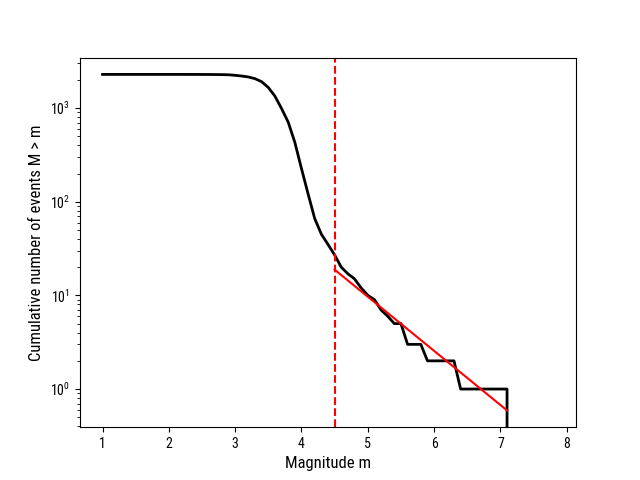

In [9]:
# Magnitude frequency for earthquakes
interval = [np.datetime64('2010-01-01'), np.datetime64('2014-06-01')]
eq_in_interval = (eq_in_region.date > interval[0]) & (eq_in_region.date < interval[1])

fig, ax = plt.subplots()

h, bins = np.histogram(eq_in_region.mag[eq_in_interval], bins=np.arange(1, 8, 0.1))
h = np.cumsum(h[::-1])[::-1]
ax.plot(bins[:-1], h, color='k', lw=2)

ax.set_xlabel('Magnitude m')
ax.set_ylabel('Cumulative number of events M > m')

from scipy.stats import linregress
x = bins[:-1][h>0]
y = np.log10(h[h>0])
mc = 4.5
ax.axvline(mc, c='r', ls='--')

slope, intercept, r_value, p_value, std_err = linregress(x[x>mc], y[x>mc])
print(slope, intercept)
ax.plot(x[x > mc], 10**(slope*x[x > mc] + intercept), 'r')

b_value = -slope
print('b-value: {:.2f}'.format(b_value))

ax.set_yscale('log')
plt.show()

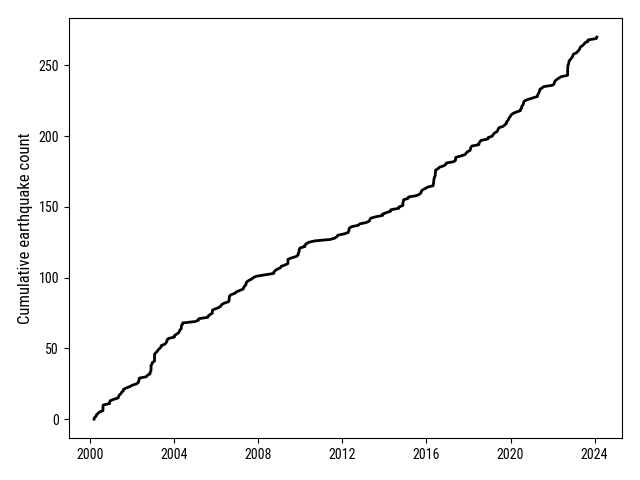

In [13]:
# Detection rate in time
fig, ax = plt.subplots()
ax.set_ylabel('Cumulative earthquake count')
times = eq_in_region.date[eq_in_region.mag > 4.5]
count = np.arange(times.shape[0])

ax.plot(times, count, color='k', lw=2)

plt.tight_layout()
plt.show()

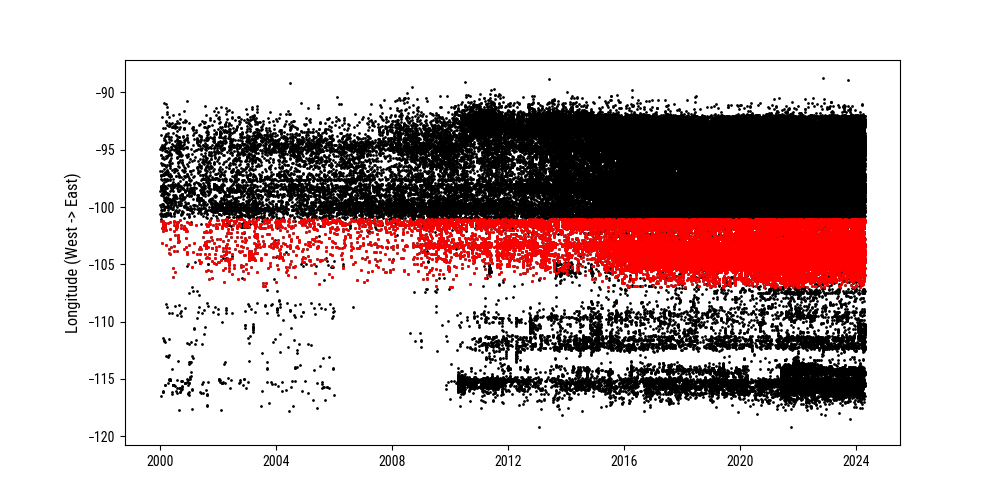

In [50]:
mag_min = 4.2
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Longitude (West -> East)')
ax.plot(eq.date[eq.mag < mag_min], eq.lon[eq.mag < mag_min], 'k.', ms=2)
ax.plot(eq_in_region.date[eq_in_region.mag < mag_min], eq_in_region.lon[eq_in_region.mag < mag_min], 'r.', ms=2)

plt.show()

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_91272/497978963.py:13: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bins[:-1], h_low_mag/h_high_mag, 'k', lw=2, label='M < 4.5')
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_91272/497978963.py:13: RuntimeWarning: invalid value encountered in divide
  ax.plot(bins[:-1], h_low_mag/h_high_mag, 'k', lw=2, label='M < 4.5')


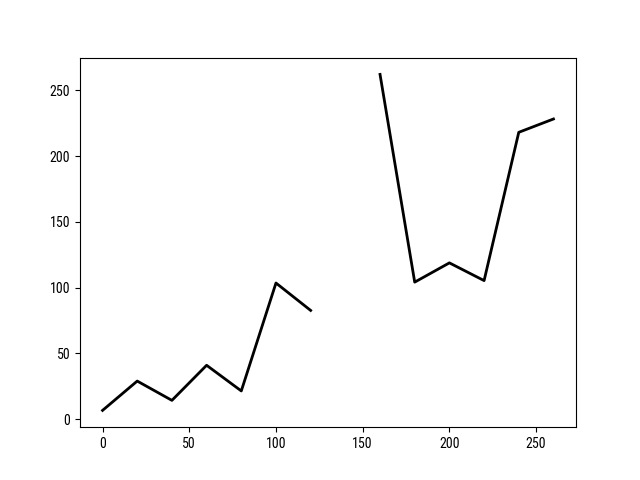

In [57]:
fig, ax = plt.subplots()

ymax = 50
around_tremor = (eq_in_region.yf < ymax) & (eq_in_region.yf > -ymax)
low_mag = eq_in_region.mag < 4.
high_mag = eq_in_region.mag >= 4.
after_date = eq_in_region.date > np.datetime64('2020-01-01')

bins = np.arange(-200, 300, 20)
h_low_mag, bins = np.histogram(eq_in_region.xf[low_mag & around_tremor & after_date], bins=bins)
h_high_mag, bins = np.histogram(eq_in_region.xf[high_mag & around_tremor & after_date], bins=bins)

ax.plot(bins[:-1], h_low_mag/h_high_mag, 'k', lw=2, label='M < 4.5')

plt.show()

# 3. <a id='toc3_'></a>Project along-strike  [&#128285;](#toc0_)

In [32]:
# Define strike
# --> Give everyone cartesian coordinates
crs = ccrs.TransverseMercator(central_latitude=np.mean(trm.lat), central_longitude=np.mean(trm.lon)) 
eq_coord = crs.transform_points(ccrs.PlateCarree(), eq_in_region.lon.values, eq_in_region.lat.values)
trm_coord = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)

eq_in_region['x'] = eq_coord[:, 0] / 1000 # easting in km
eq_in_region['y'] = eq_coord[:, 1] / 1000 # northing in km
trm['x'] = trm_coord[:, 0] / 1000 
trm['y'] = trm_coord[:, 1] / 1000 

# --> Fit strike as polynomial
p_strike = np.polyfit(trm.x, trm.y, 2)

# --> Define strike line
x0 = -200
y0 = np.polyval(p_strike, x0)
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
x = x0
while x < 300:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dx = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), x))**2)
    x += dx
    y = np.polyval(p_strike, x)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> "Project" earthquakes along strike, find nearest neighbor to strike line
from scipy.spatial import cKDTree
tree_strike = cKDTree(np.column_stack([X, Y]))

eq_across_strike_dist, eq_nearest_idx = tree_strike.query(np.column_stack((eq_in_region.x, eq_in_region.y)))
trm_across_strike_dist, trm_nearest_idx = tree_strike.query(np.column_stack((trm.x, trm.y)))

eq_along_strike_dist = S[eq_nearest_idx]
trm_along_strike_dist = S[trm_nearest_idx]

eq_in_region['xf'] = eq_along_strike_dist  # xf or xfault: along-strike distance in km
eq_in_region['yf'] = eq_across_strike_dist  # yf or yfault: across-strike distance in km
trm['xf'] = trm_along_strike_dist
trm['yf'] = trm_across_strike_dist

# Show
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('y (km)')  
#     ax.set_ylabel('x (km)')
#     ax.plot(X, Y, 'r', zorder=10)

# axes[0].scatter(eq_in_region.x, eq_in_region.y, s=eq_in_region.mag**2, c=eq_along_strike_dist, cmap='viridis', vmin=0, vmax=500)
# axes[0].scatter(trm.x, trm.y, s=3, c='k')
# axes[0].scatter(trm.x, trm.y, s=1, c=trm_along_strike_dist, cmap='viridis', vmin=0, vmax=500)

# axes[1].scatter(eq_in_region.x, eq_in_region.y, s=eq_in_region.mag**2, c=eq_across_strike_dist, cmap='viridis', vmin=0, vmax=200)
# axes[1].scatter(trm.x, trm.y, s=3, c='k')
# axes[1].scatter(trm.x, trm.y, s=1, c=trm_across_strike_dist, cmap='viridis', vmin=0, vmax=200)

# plt.tight_layout()
# plt.show()

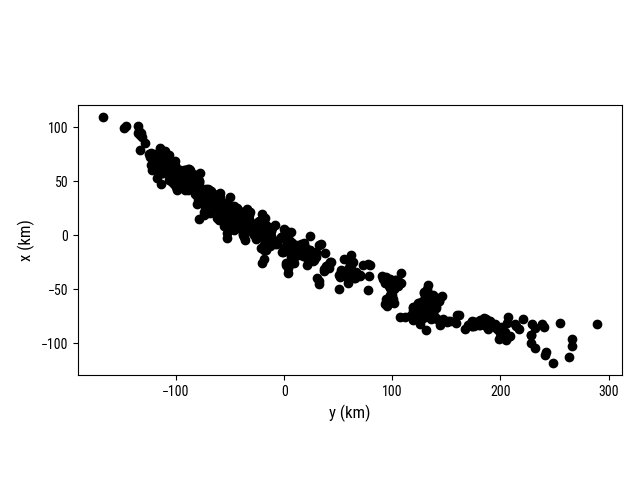

In [33]:
# Trim?
y_max = 30
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('y (km)')
ax.set_ylabel('x (km)')

ax.plot(trm.x, trm.y, 'ko', zorder=10)
ax.plot(trm.x[trm.yf > y_max], trm.y[trm.yf > y_max], 'ro', zorder=10)

plt.tight_layout()
plt.show()

In [34]:
# Trim
trm = trm[trm.yf < y_max]

In [ ]:
fig, ax = plt.subplots()


# 4. <a id='toc4_'></a>Count earthquakes that can trigger tremor  [&#128285;](#toc0_)

In [38]:
# Which earthquakes
epicentral = False

mag_min = mc
mag_rate = 1.8  # magnitude to extrapolate rate to
date_min = np.datetime64('2010-01-01')

selected_eq = eq_in_region[(eq_in_region.mag > mag_min) & (eq_in_region.date > date_min)].copy()
print(f'{selected_eq.shape[0]} selected earthquakes above {mag_min:.2f}')
print('Chosen b: {:.2f}'.format(b_value))

8773 selected earthquakes above 3.70
Chosen b: 1.17


In [39]:
# Count number of earthquakes at distance (ball-tree counting, approximate but fast)
dists = [10, 20, 30, 50, 100]

n_eq = np.zeros((len(dists), len(trm)))   # number of earthquakes at given distance of each tremor event
eq_at_dist = np.zeros((len(dists), len(selected_eq))).astype(bool)  # boolean array to keep track of which earthquakes are within given distance from any tremor

# Build K-D trees
if epicentral:
    eq_tree = cKDTree(selected_eq[['x', 'y']].values)
    trm_tree = cKDTree(trm[['x', 'y']].values)
else:
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)

# Look for pairs of earthquakes and tremors within distance
for jj, dist in enumerate(dists):
    # Find earthquakes within distance of tremors
    eq_idx = trm_tree.query_ball_tree(eq_tree, dist)
    
    # --> How earthquakes at distance from tremor
    n_eq[jj, :] = np.array([len(e) for e in eq_idx])
    
    # --> Which ones
    eq_at_dist_idx = np.concatenate(eq_idx)
    eq_at_dist_idx = np.unique(eq_at_dist_idx).astype(int)
    eq_at_dist[jj, eq_at_dist_idx] = True

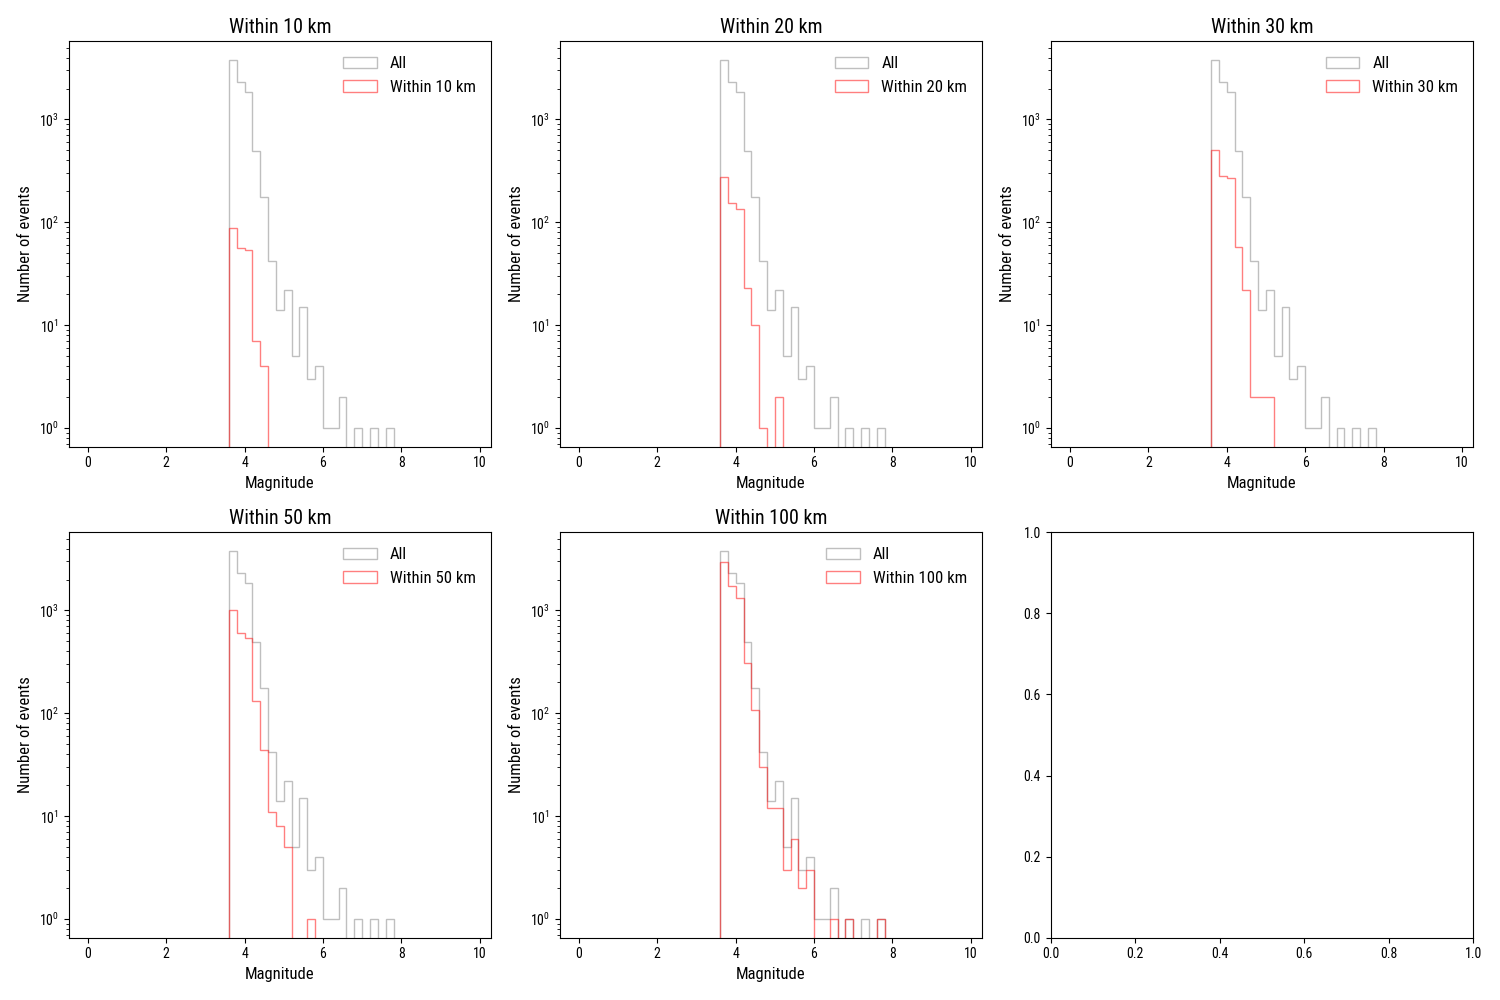

In [93]:
# Magnitude of completeness of each group
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for jj, dist in enumerate(dists):
    ax = axes.flat[jj]
    ax.hist(selected_eq.mag.values, bins=np.arange(0, 10, .2), color='gray', alpha=.5, label='All', histtype='step', zorder=0)
    ax.hist(selected_eq.mag.values[eq_at_dist[jj]], bins=np.arange(0, 10, .2), color='red', alpha=.5, label='Within {:d} km'.format(dist), histtype='step', zorder=1)
    ax.set_title('Within {:d} km'.format(dist))
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Number of events')
    ax.set_yscale('log')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [94]:
# Convert counts to rates per year, at a given magnitude
n_eq = n_eq / ((selected_eq.date.max() - selected_eq.date.min()).days / 365)
n_eq = n_eq * 10**(-b_value*(mag_rate - mag_min))

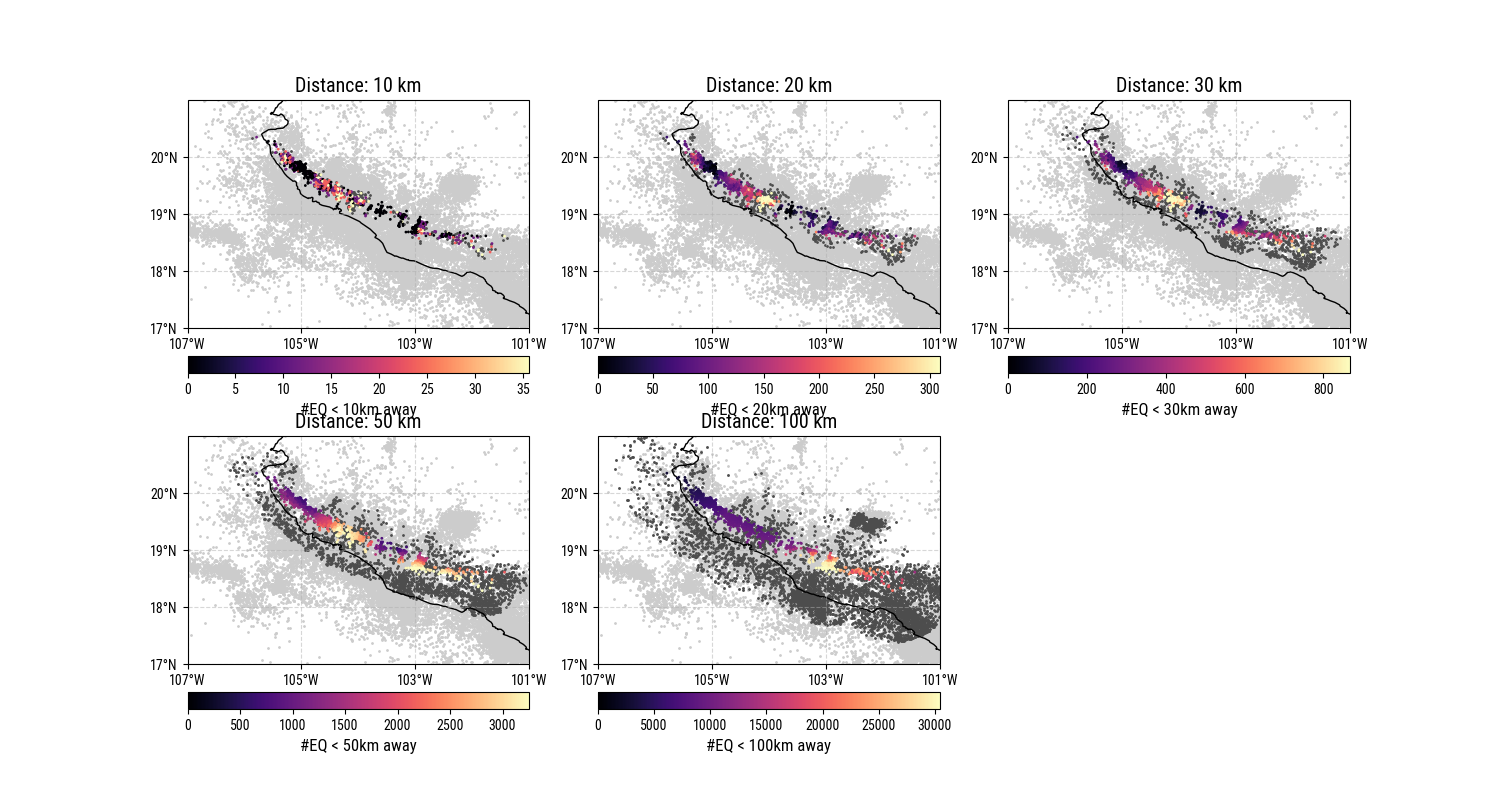

In [95]:
# Plot it
lon_min = -107
lon_max = -101
lat_min = 17
lat_max = 21
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(15, 8))
axes = [plt.subplot(2, 3, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(dists)), axes):
    ax.set_title('Distance: {:d} km'.format(dists[ii]))
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=n_eq[ii, :], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(n_eq[ii, :], 95), zorder=2, label='Tremor')
    ax.scatter(selected_eq.lon[eq_at_dist[ii]], selected_eq.lat[eq_at_dist[ii]], c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(dists[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    #ax.legend(loc='lower left', fontsize='small', framealpha=.5, scatterpoints=10, markerscale=3)

    # # Colorbar
    # x_min_ax = 0.5; y_min_ax = 0.3
    # w_ax = 0.45; h_ax = 0.05
    # x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    # x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    # x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    # h_fig = y_max_fig - y_min_fig
    # w_fig = x_max_fig - x_min_fig

    # cb = fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    # cbar = plt.colorbar(sc, cax=cb, orientation='horizontal', label="#EQ < {:d}km away".format(dists[ii]))
    plt.colorbar(sc, orientation='horizontal', label="#EQ < {:d}km away".format(dists[ii]), pad=0.1, fraction=0.07)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

# plt.tight_layout()
plt.show()

In [96]:
# Save it
trm.loc[:, 'n_eq_10km'] = n_eq[0, :]
trm.loc[:, 'n_eq_20km'] = n_eq[1, :]
trm.loc[:, 'n_eq_30km'] = n_eq[2, :]    
trm.loc[:, 'n_eq_50km'] = n_eq[3, :]
trm.loc[:, 'n_eq_100km'] = n_eq[4, :]

trm.to_csv('data/mexico/processed/mex_trm_0106_0607_eqdist_mc{:.1f}.csv'.format(mag_rate), index=False)

# Save the earthquakes
selected_eq.loc[:, 'in10km'] = eq_at_dist[0, :]
selected_eq.loc[:, 'in20km'] = eq_at_dist[1, :]
selected_eq.loc[:, 'in30km'] = eq_at_dist[2, :]
selected_eq.loc[:, 'in50km'] = eq_at_dist[3, :]
selected_eq.loc[:, 'in100km'] = eq_at_dist[4, :]

selected_eq.to_csv('data/mexico/processed/mex_eqmc{:.1f}_0106_0607_eqdist.csv'.format(mag_rate), index=False)